# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

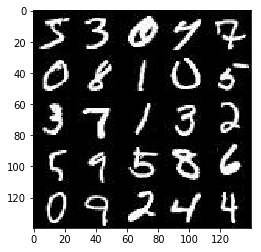

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

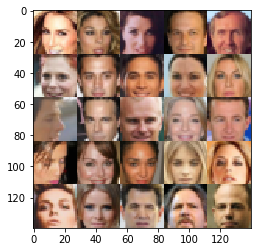

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\8050116\AppData\Local\conda\conda\envs\nd101\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_inputs = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [46]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        shape = relu3.get_shape()
        
        
        flat = tf.reshape(relu3, [-1, int(shape[1]*shape[2]*shape[3])])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        fc1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(fc1, [-1, 7, 7, 512])
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [48]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [49]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [53]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 20... Discriminator Loss: 2.9514... Generator Loss: 0.1072
Epoch 1/2... Step 40... Discriminator Loss: 2.3820... Generator Loss: 0.6084
Epoch 1/2... Step 60... Discriminator Loss: 1.8234... Generator Loss: 0.5085
Epoch 1/2... Step 80... Discriminator Loss: 1.4595... Generator Loss: 0.6097
Epoch 1/2... Step 100... Discriminator Loss: 1.7498... Generator Loss: 0.6097


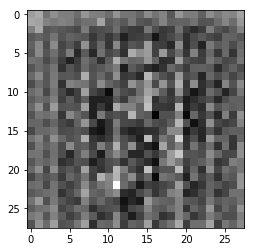

Epoch 1/2... Step 120... Discriminator Loss: 1.6725... Generator Loss: 0.2780
Epoch 1/2... Step 140... Discriminator Loss: 1.1818... Generator Loss: 1.0895
Epoch 1/2... Step 160... Discriminator Loss: 1.2749... Generator Loss: 0.5277
Epoch 1/2... Step 180... Discriminator Loss: 1.2159... Generator Loss: 1.2340
Epoch 1/2... Step 200... Discriminator Loss: 1.1515... Generator Loss: 1.6772


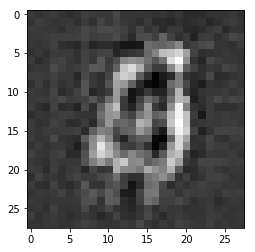

Epoch 1/2... Step 220... Discriminator Loss: 1.0068... Generator Loss: 1.0863
Epoch 1/2... Step 240... Discriminator Loss: 1.4221... Generator Loss: 0.3879
Epoch 1/2... Step 260... Discriminator Loss: 0.8834... Generator Loss: 0.9533
Epoch 1/2... Step 280... Discriminator Loss: 1.0196... Generator Loss: 0.7810
Epoch 1/2... Step 300... Discriminator Loss: 1.3184... Generator Loss: 0.4041


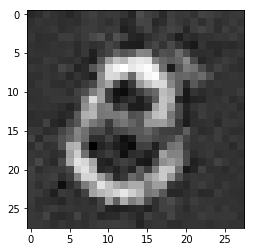

Epoch 1/2... Step 320... Discriminator Loss: 2.2340... Generator Loss: 0.1302
Epoch 1/2... Step 340... Discriminator Loss: 0.9537... Generator Loss: 0.9255
Epoch 1/2... Step 360... Discriminator Loss: 1.3028... Generator Loss: 0.4293
Epoch 1/2... Step 380... Discriminator Loss: 0.5200... Generator Loss: 1.8239
Epoch 1/2... Step 400... Discriminator Loss: 1.2665... Generator Loss: 0.4107


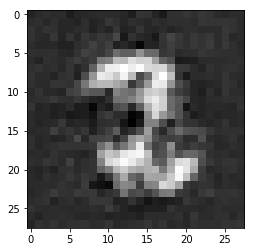

Epoch 1/2... Step 420... Discriminator Loss: 0.3753... Generator Loss: 2.0735
Epoch 1/2... Step 440... Discriminator Loss: 2.6770... Generator Loss: 1.6236
Epoch 1/2... Step 460... Discriminator Loss: 0.9244... Generator Loss: 0.7080
Epoch 1/2... Step 480... Discriminator Loss: 0.3485... Generator Loss: 3.1300
Epoch 1/2... Step 500... Discriminator Loss: 1.1000... Generator Loss: 0.5228


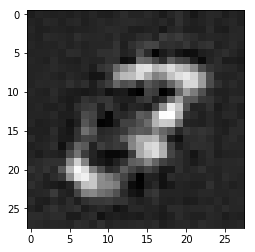

Epoch 1/2... Step 520... Discriminator Loss: 1.4758... Generator Loss: 0.3378
Epoch 1/2... Step 540... Discriminator Loss: 0.6018... Generator Loss: 1.0717
Epoch 1/2... Step 560... Discriminator Loss: 1.2738... Generator Loss: 0.4282
Epoch 1/2... Step 580... Discriminator Loss: 0.5708... Generator Loss: 1.0009
Epoch 1/2... Step 600... Discriminator Loss: 0.2933... Generator Loss: 2.0914


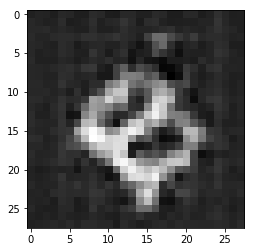

Epoch 1/2... Step 620... Discriminator Loss: 1.0600... Generator Loss: 0.5355
Epoch 1/2... Step 640... Discriminator Loss: 0.8738... Generator Loss: 0.7656
Epoch 1/2... Step 660... Discriminator Loss: 0.7431... Generator Loss: 0.8712
Epoch 1/2... Step 680... Discriminator Loss: 2.1336... Generator Loss: 0.1571
Epoch 1/2... Step 700... Discriminator Loss: 0.6742... Generator Loss: 0.9768


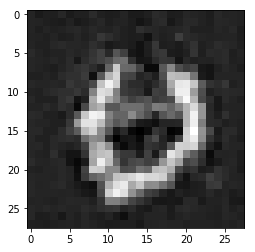

Epoch 1/2... Step 720... Discriminator Loss: 0.7558... Generator Loss: 0.7673
Epoch 1/2... Step 740... Discriminator Loss: 0.3252... Generator Loss: 1.8033
Epoch 1/2... Step 760... Discriminator Loss: 0.4800... Generator Loss: 1.3344
Epoch 1/2... Step 780... Discriminator Loss: 1.3826... Generator Loss: 0.3627
Epoch 1/2... Step 800... Discriminator Loss: 0.6993... Generator Loss: 0.8964


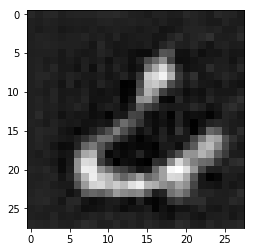

Epoch 1/2... Step 820... Discriminator Loss: 0.9665... Generator Loss: 0.6886
Epoch 1/2... Step 840... Discriminator Loss: 0.2261... Generator Loss: 2.4194
Epoch 1/2... Step 860... Discriminator Loss: 0.6503... Generator Loss: 0.9409
Epoch 1/2... Step 880... Discriminator Loss: 1.1254... Generator Loss: 0.5171
Epoch 1/2... Step 900... Discriminator Loss: 0.1397... Generator Loss: 4.2666


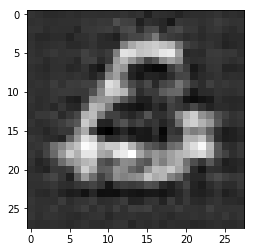

Epoch 1/2... Step 920... Discriminator Loss: 0.6125... Generator Loss: 0.9692
Epoch 2/2... Step 3... Discriminator Loss: 0.5235... Generator Loss: 1.2020
Epoch 2/2... Step 23... Discriminator Loss: 0.8507... Generator Loss: 0.7481
Epoch 2/2... Step 43... Discriminator Loss: 0.6200... Generator Loss: 1.0317
Epoch 2/2... Step 63... Discriminator Loss: 1.3733... Generator Loss: 0.3576


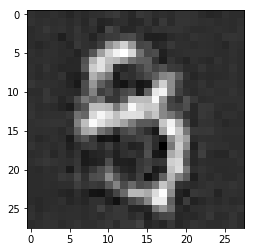

Epoch 2/2... Step 83... Discriminator Loss: 0.5018... Generator Loss: 1.1970
Epoch 2/2... Step 103... Discriminator Loss: 0.5082... Generator Loss: 1.1824
Epoch 2/2... Step 123... Discriminator Loss: 2.2353... Generator Loss: 0.1386
Epoch 2/2... Step 143... Discriminator Loss: 0.7684... Generator Loss: 0.9048
Epoch 2/2... Step 163... Discriminator Loss: 0.2694... Generator Loss: 4.0664


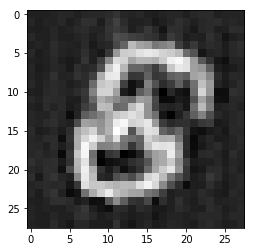

Epoch 2/2... Step 183... Discriminator Loss: 0.8151... Generator Loss: 0.7391
Epoch 2/2... Step 203... Discriminator Loss: 0.4155... Generator Loss: 1.4798
Epoch 2/2... Step 223... Discriminator Loss: 0.2311... Generator Loss: 2.2104
Epoch 2/2... Step 243... Discriminator Loss: 1.6501... Generator Loss: 0.2591
Epoch 2/2... Step 263... Discriminator Loss: 1.4478... Generator Loss: 0.3222


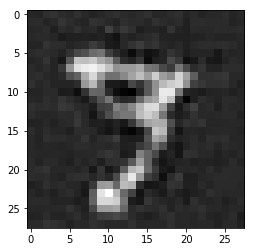

Epoch 2/2... Step 283... Discriminator Loss: 0.7638... Generator Loss: 0.7673
Epoch 2/2... Step 303... Discriminator Loss: 0.1901... Generator Loss: 2.3204
Epoch 2/2... Step 323... Discriminator Loss: 0.1630... Generator Loss: 3.6225
Epoch 2/2... Step 343... Discriminator Loss: 1.0336... Generator Loss: 0.5819
Epoch 2/2... Step 363... Discriminator Loss: 0.3031... Generator Loss: 2.4045


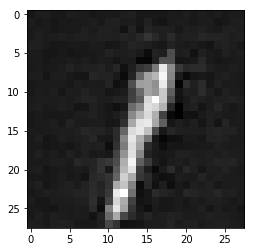

Epoch 2/2... Step 383... Discriminator Loss: 0.7014... Generator Loss: 1.5518
Epoch 2/2... Step 403... Discriminator Loss: 1.2631... Generator Loss: 0.4074
Epoch 2/2... Step 423... Discriminator Loss: 0.0980... Generator Loss: 4.7612
Epoch 2/2... Step 443... Discriminator Loss: 0.7816... Generator Loss: 1.8838
Epoch 2/2... Step 463... Discriminator Loss: 1.5955... Generator Loss: 0.2899


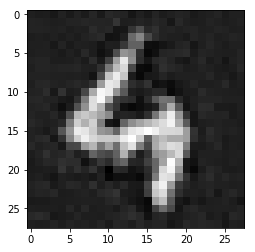

Epoch 2/2... Step 483... Discriminator Loss: 1.6141... Generator Loss: 0.3096
Epoch 2/2... Step 503... Discriminator Loss: 0.4872... Generator Loss: 1.1960
Epoch 2/2... Step 523... Discriminator Loss: 1.1539... Generator Loss: 0.6014
Epoch 2/2... Step 543... Discriminator Loss: 0.7668... Generator Loss: 0.8865
Epoch 2/2... Step 563... Discriminator Loss: 0.4144... Generator Loss: 1.3551


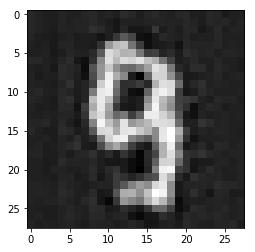

Epoch 2/2... Step 583... Discriminator Loss: 0.3147... Generator Loss: 1.5669
Epoch 2/2... Step 603... Discriminator Loss: 0.3539... Generator Loss: 1.5325
Epoch 2/2... Step 623... Discriminator Loss: 0.3229... Generator Loss: 1.9652
Epoch 2/2... Step 643... Discriminator Loss: 1.0047... Generator Loss: 0.5535
Epoch 2/2... Step 663... Discriminator Loss: 0.2160... Generator Loss: 2.2549


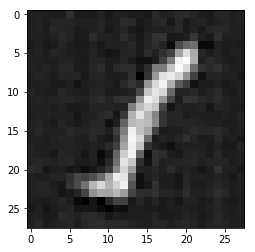

Epoch 2/2... Step 683... Discriminator Loss: 2.3758... Generator Loss: 0.1494
Epoch 2/2... Step 703... Discriminator Loss: 0.6151... Generator Loss: 1.9829
Epoch 2/2... Step 723... Discriminator Loss: 0.2766... Generator Loss: 1.7411
Epoch 2/2... Step 743... Discriminator Loss: 0.1356... Generator Loss: 2.6301
Epoch 2/2... Step 763... Discriminator Loss: 1.2848... Generator Loss: 0.3925


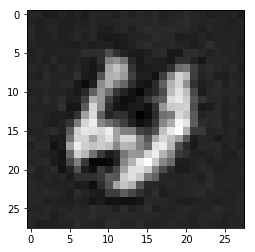

Epoch 2/2... Step 783... Discriminator Loss: 0.7662... Generator Loss: 0.8584
Epoch 2/2... Step 803... Discriminator Loss: 0.5697... Generator Loss: 1.0833
Epoch 2/2... Step 823... Discriminator Loss: 0.1049... Generator Loss: 2.7268
Epoch 2/2... Step 843... Discriminator Loss: 2.4219... Generator Loss: 0.1702
Epoch 2/2... Step 863... Discriminator Loss: 0.7667... Generator Loss: 1.0601


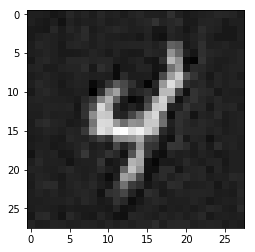

Epoch 2/2... Step 883... Discriminator Loss: 0.7179... Generator Loss: 2.0742
Epoch 2/2... Step 903... Discriminator Loss: 0.2890... Generator Loss: 2.4036
Epoch 2/2... Step 923... Discriminator Loss: 0.1294... Generator Loss: 4.1223


IndexError: list index out of range

In [52]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 20... Discriminator Loss: 4.7084... Generator Loss: 0.0335
Epoch 1/1... Step 40... Discriminator Loss: 2.5087... Generator Loss: 0.2940
Epoch 1/1... Step 60... Discriminator Loss: 2.7106... Generator Loss: 0.2168
Epoch 1/1... Step 80... Discriminator Loss: 2.5215... Generator Loss: 0.2809
Epoch 1/1... Step 100... Discriminator Loss: 2.3504... Generator Loss: 0.3857


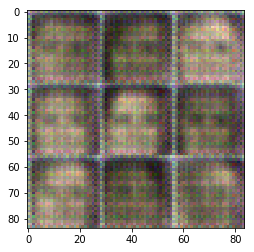

Epoch 1/1... Step 120... Discriminator Loss: 1.8235... Generator Loss: 0.3697
Epoch 1/1... Step 140... Discriminator Loss: 1.7827... Generator Loss: 0.4710
Epoch 1/1... Step 160... Discriminator Loss: 1.6093... Generator Loss: 0.4701
Epoch 1/1... Step 180... Discriminator Loss: 1.7094... Generator Loss: 0.4050
Epoch 1/1... Step 200... Discriminator Loss: 1.6736... Generator Loss: 0.5230


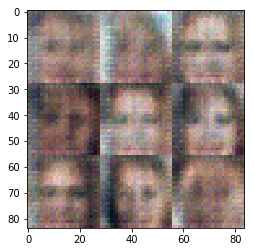

Epoch 1/1... Step 220... Discriminator Loss: 1.7171... Generator Loss: 0.5537
Epoch 1/1... Step 240... Discriminator Loss: 1.6283... Generator Loss: 0.5142
Epoch 1/1... Step 260... Discriminator Loss: 1.6878... Generator Loss: 0.5130
Epoch 1/1... Step 280... Discriminator Loss: 1.6081... Generator Loss: 0.5130
Epoch 1/1... Step 300... Discriminator Loss: 1.6776... Generator Loss: 0.5211


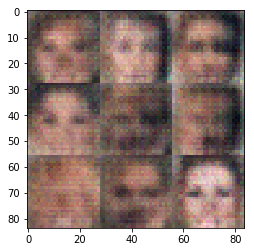

Epoch 1/1... Step 320... Discriminator Loss: 1.5417... Generator Loss: 0.6013
Epoch 1/1... Step 340... Discriminator Loss: 1.6308... Generator Loss: 0.4981
Epoch 1/1... Step 360... Discriminator Loss: 1.7674... Generator Loss: 0.4682
Epoch 1/1... Step 380... Discriminator Loss: 1.6037... Generator Loss: 0.5320
Epoch 1/1... Step 400... Discriminator Loss: 1.5772... Generator Loss: 0.5447


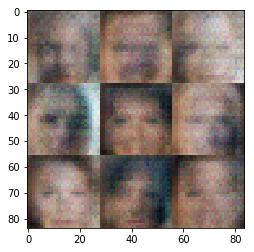

Epoch 1/1... Step 420... Discriminator Loss: 1.6539... Generator Loss: 0.5222
Epoch 1/1... Step 440... Discriminator Loss: 1.5578... Generator Loss: 0.6264
Epoch 1/1... Step 460... Discriminator Loss: 1.5708... Generator Loss: 0.4935
Epoch 1/1... Step 480... Discriminator Loss: 1.5196... Generator Loss: 0.5327
Epoch 1/1... Step 500... Discriminator Loss: 1.5083... Generator Loss: 0.5581


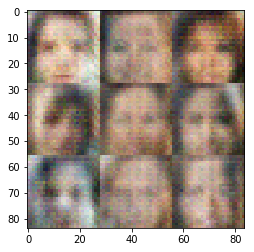

Epoch 1/1... Step 520... Discriminator Loss: 1.5550... Generator Loss: 0.5603
Epoch 1/1... Step 540... Discriminator Loss: 1.5023... Generator Loss: 0.5319
Epoch 1/1... Step 560... Discriminator Loss: 1.0536... Generator Loss: 1.0448
Epoch 1/1... Step 580... Discriminator Loss: 1.2088... Generator Loss: 0.6199
Epoch 1/1... Step 600... Discriminator Loss: 2.1084... Generator Loss: 2.8245


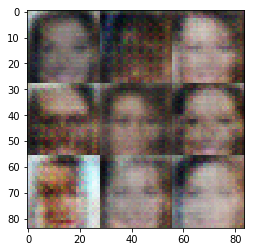

Epoch 1/1... Step 620... Discriminator Loss: 2.0477... Generator Loss: 0.1883
Epoch 1/1... Step 640... Discriminator Loss: 0.3434... Generator Loss: 1.8890
Epoch 1/1... Step 660... Discriminator Loss: 1.1213... Generator Loss: 0.4454
Epoch 1/1... Step 680... Discriminator Loss: 0.9128... Generator Loss: 1.0519
Epoch 1/1... Step 700... Discriminator Loss: 1.4359... Generator Loss: 2.9474


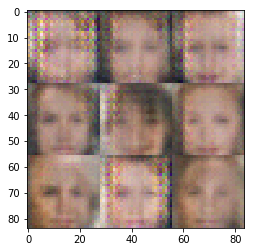

Epoch 1/1... Step 720... Discriminator Loss: 1.5124... Generator Loss: 0.3171
Epoch 1/1... Step 740... Discriminator Loss: 1.2672... Generator Loss: 0.5681
Epoch 1/1... Step 760... Discriminator Loss: 1.6818... Generator Loss: 0.2820
Epoch 1/1... Step 780... Discriminator Loss: 1.5504... Generator Loss: 0.4613
Epoch 1/1... Step 800... Discriminator Loss: 1.0342... Generator Loss: 1.2290


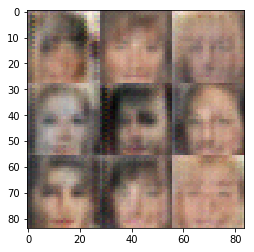

Epoch 1/1... Step 820... Discriminator Loss: 1.0299... Generator Loss: 0.9441
Epoch 1/1... Step 840... Discriminator Loss: 1.7793... Generator Loss: 0.3617
Epoch 1/1... Step 860... Discriminator Loss: 1.4695... Generator Loss: 0.6798
Epoch 1/1... Step 880... Discriminator Loss: 1.5170... Generator Loss: 0.5444
Epoch 1/1... Step 900... Discriminator Loss: 1.4478... Generator Loss: 0.5812


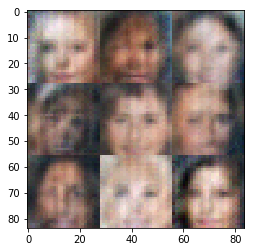

Epoch 1/1... Step 920... Discriminator Loss: 1.6819... Generator Loss: 0.5188
Epoch 1/1... Step 940... Discriminator Loss: 1.5666... Generator Loss: 0.5919
Epoch 1/1... Step 960... Discriminator Loss: 1.5157... Generator Loss: 0.6000
Epoch 1/1... Step 980... Discriminator Loss: 1.5208... Generator Loss: 0.6296
Epoch 1/1... Step 1000... Discriminator Loss: 1.5372... Generator Loss: 0.5647


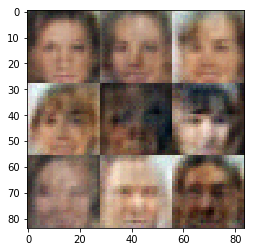

Epoch 1/1... Step 1020... Discriminator Loss: 1.5658... Generator Loss: 0.5707
Epoch 1/1... Step 1040... Discriminator Loss: 1.5593... Generator Loss: 0.5814
Epoch 1/1... Step 1060... Discriminator Loss: 1.5864... Generator Loss: 0.6091
Epoch 1/1... Step 1080... Discriminator Loss: 1.4428... Generator Loss: 0.6199
Epoch 1/1... Step 1100... Discriminator Loss: 1.5383... Generator Loss: 0.5698


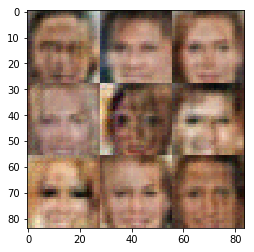

Epoch 1/1... Step 1120... Discriminator Loss: 1.4702... Generator Loss: 0.6028
Epoch 1/1... Step 1140... Discriminator Loss: 1.6585... Generator Loss: 0.5574
Epoch 1/1... Step 1160... Discriminator Loss: 1.4273... Generator Loss: 0.6288
Epoch 1/1... Step 1180... Discriminator Loss: 1.4462... Generator Loss: 0.6313
Epoch 1/1... Step 1200... Discriminator Loss: 1.4421... Generator Loss: 0.6226


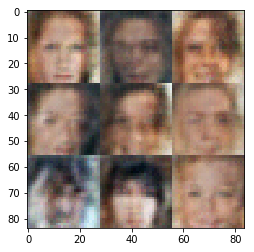

Epoch 1/1... Step 1220... Discriminator Loss: 1.5022... Generator Loss: 0.5730
Epoch 1/1... Step 1240... Discriminator Loss: 1.5307... Generator Loss: 0.5803
Epoch 1/1... Step 1260... Discriminator Loss: 1.5122... Generator Loss: 0.5732
Epoch 1/1... Step 1280... Discriminator Loss: 1.5361... Generator Loss: 0.6015
Epoch 1/1... Step 1300... Discriminator Loss: 1.5881... Generator Loss: 0.5841


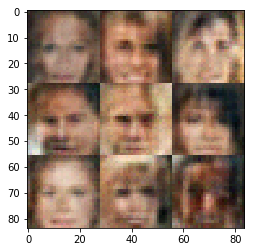

Epoch 1/1... Step 1320... Discriminator Loss: 1.4210... Generator Loss: 0.6051
Epoch 1/1... Step 1340... Discriminator Loss: 1.4056... Generator Loss: 0.6455
Epoch 1/1... Step 1360... Discriminator Loss: 1.4568... Generator Loss: 0.6201
Epoch 1/1... Step 1380... Discriminator Loss: 1.4988... Generator Loss: 0.5476
Epoch 1/1... Step 1400... Discriminator Loss: 1.6029... Generator Loss: 0.5473


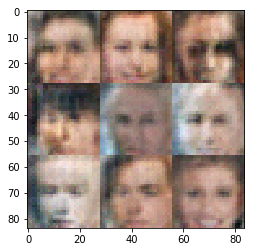

Epoch 1/1... Step 1420... Discriminator Loss: 1.4753... Generator Loss: 0.6409
Epoch 1/1... Step 1440... Discriminator Loss: 1.5040... Generator Loss: 0.5310
Epoch 1/1... Step 1460... Discriminator Loss: 1.5388... Generator Loss: 0.6066
Epoch 1/1... Step 1480... Discriminator Loss: 1.3785... Generator Loss: 0.6542
Epoch 1/1... Step 1500... Discriminator Loss: 1.4140... Generator Loss: 0.6273


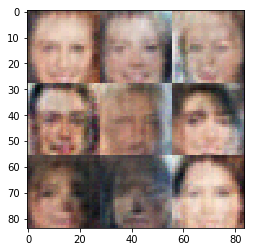

Epoch 1/1... Step 1520... Discriminator Loss: 1.5953... Generator Loss: 0.5782
Epoch 1/1... Step 1540... Discriminator Loss: 1.4352... Generator Loss: 0.6505
Epoch 1/1... Step 1560... Discriminator Loss: 1.5146... Generator Loss: 0.6368
Epoch 1/1... Step 1580... Discriminator Loss: 1.2837... Generator Loss: 0.6720
Epoch 1/1... Step 1600... Discriminator Loss: 0.8770... Generator Loss: 1.3762


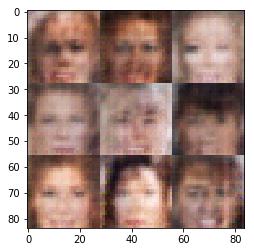

Epoch 1/1... Step 1620... Discriminator Loss: 0.8895... Generator Loss: 0.9992
Epoch 1/1... Step 1640... Discriminator Loss: 1.0296... Generator Loss: 1.0526
Epoch 1/1... Step 1660... Discriminator Loss: 0.4616... Generator Loss: 3.0063
Epoch 1/1... Step 1680... Discriminator Loss: 1.0323... Generator Loss: 0.5879
Epoch 1/1... Step 1700... Discriminator Loss: 0.7057... Generator Loss: 1.2657


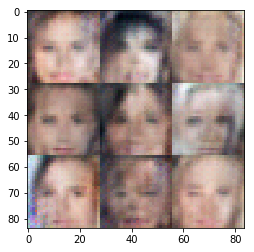

Epoch 1/1... Step 1720... Discriminator Loss: 1.7115... Generator Loss: 1.4108
Epoch 1/1... Step 1740... Discriminator Loss: 1.3151... Generator Loss: 0.5545
Epoch 1/1... Step 1760... Discriminator Loss: 0.4918... Generator Loss: 1.2521
Epoch 1/1... Step 1780... Discriminator Loss: 2.1970... Generator Loss: 0.2177
Epoch 1/1... Step 1800... Discriminator Loss: 1.8146... Generator Loss: 0.2536


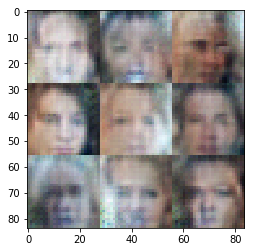

Epoch 1/1... Step 1820... Discriminator Loss: 0.6758... Generator Loss: 1.3092
Epoch 1/1... Step 1840... Discriminator Loss: 1.1207... Generator Loss: 1.4305
Epoch 1/1... Step 1860... Discriminator Loss: 1.2624... Generator Loss: 0.7498
Epoch 1/1... Step 1880... Discriminator Loss: 0.6506... Generator Loss: 1.0230
Epoch 1/1... Step 1900... Discriminator Loss: 2.2586... Generator Loss: 0.1765


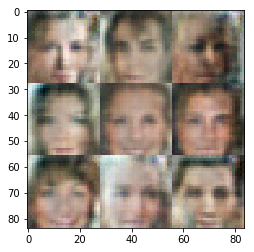

Epoch 1/1... Step 1920... Discriminator Loss: 1.0676... Generator Loss: 0.6006
Epoch 1/1... Step 1940... Discriminator Loss: 0.5941... Generator Loss: 1.2058
Epoch 1/1... Step 1960... Discriminator Loss: 0.5204... Generator Loss: 1.2134
Epoch 1/1... Step 1980... Discriminator Loss: 0.2405... Generator Loss: 3.1290
Epoch 1/1... Step 2000... Discriminator Loss: 0.3846... Generator Loss: 3.4449


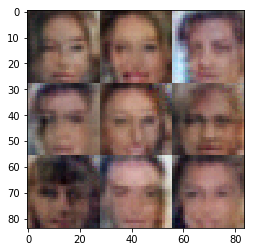

Epoch 1/1... Step 2020... Discriminator Loss: 2.2570... Generator Loss: 0.1318
Epoch 1/1... Step 2040... Discriminator Loss: 1.6146... Generator Loss: 0.2901
Epoch 1/1... Step 2060... Discriminator Loss: 1.0071... Generator Loss: 0.6828
Epoch 1/1... Step 2080... Discriminator Loss: 1.5186... Generator Loss: 0.6527
Epoch 1/1... Step 2100... Discriminator Loss: 1.7957... Generator Loss: 0.2700


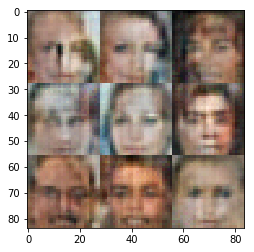

Epoch 1/1... Step 2120... Discriminator Loss: 0.9574... Generator Loss: 0.7401
Epoch 1/1... Step 2140... Discriminator Loss: 2.3744... Generator Loss: 0.4362
Epoch 1/1... Step 2160... Discriminator Loss: 1.6460... Generator Loss: 0.4354
Epoch 1/1... Step 2180... Discriminator Loss: 0.8996... Generator Loss: 0.9621
Epoch 1/1... Step 2200... Discriminator Loss: 1.7583... Generator Loss: 0.2726


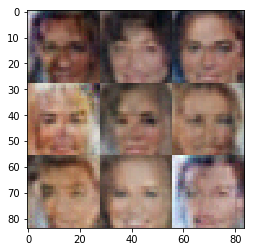

Epoch 1/1... Step 2220... Discriminator Loss: 1.5012... Generator Loss: 0.3743
Epoch 1/1... Step 2240... Discriminator Loss: 1.3588... Generator Loss: 0.7605
Epoch 1/1... Step 2260... Discriminator Loss: 0.8076... Generator Loss: 2.0817
Epoch 1/1... Step 2280... Discriminator Loss: 0.5969... Generator Loss: 1.5385
Epoch 1/1... Step 2300... Discriminator Loss: 1.2361... Generator Loss: 1.1932


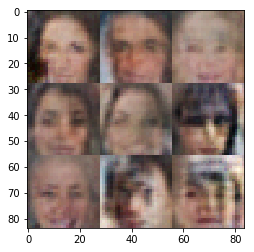

Epoch 1/1... Step 2320... Discriminator Loss: 1.4710... Generator Loss: 2.9143
Epoch 1/1... Step 2340... Discriminator Loss: 1.6370... Generator Loss: 0.5916
Epoch 1/1... Step 2360... Discriminator Loss: 1.4837... Generator Loss: 0.5212
Epoch 1/1... Step 2380... Discriminator Loss: 1.6021... Generator Loss: 0.5158
Epoch 1/1... Step 2400... Discriminator Loss: 1.3480... Generator Loss: 0.7283


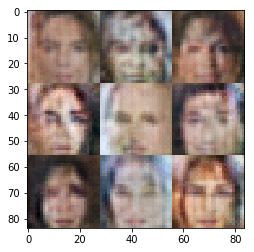

Epoch 1/1... Step 2420... Discriminator Loss: 1.6776... Generator Loss: 0.4639
Epoch 1/1... Step 2440... Discriminator Loss: 1.3726... Generator Loss: 0.5113
Epoch 1/1... Step 2460... Discriminator Loss: 0.6929... Generator Loss: 2.5322
Epoch 1/1... Step 2480... Discriminator Loss: 0.6185... Generator Loss: 1.1591
Epoch 1/1... Step 2500... Discriminator Loss: 0.4822... Generator Loss: 2.6860


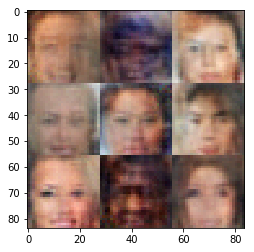

Epoch 1/1... Step 2520... Discriminator Loss: 0.7943... Generator Loss: 1.1678
Epoch 1/1... Step 2540... Discriminator Loss: 0.8678... Generator Loss: 0.7658
Epoch 1/1... Step 2560... Discriminator Loss: 0.4240... Generator Loss: 1.4838
Epoch 1/1... Step 2580... Discriminator Loss: 1.8313... Generator Loss: 0.4840
Epoch 1/1... Step 2600... Discriminator Loss: 1.3620... Generator Loss: 0.6724


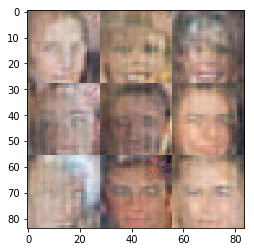

Epoch 1/1... Step 2620... Discriminator Loss: 1.4598... Generator Loss: 0.6197
Epoch 1/1... Step 2640... Discriminator Loss: 1.4411... Generator Loss: 0.5947
Epoch 1/1... Step 2660... Discriminator Loss: 1.3759... Generator Loss: 0.6264
Epoch 1/1... Step 2680... Discriminator Loss: 1.5467... Generator Loss: 0.5825
Epoch 1/1... Step 2700... Discriminator Loss: 1.5122... Generator Loss: 0.5501


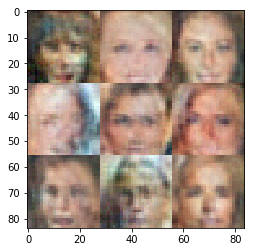

Epoch 1/1... Step 2720... Discriminator Loss: 1.2522... Generator Loss: 0.7204
Epoch 1/1... Step 2740... Discriminator Loss: 1.7518... Generator Loss: 0.2873
Epoch 1/1... Step 2760... Discriminator Loss: 0.5376... Generator Loss: 1.3493
Epoch 1/1... Step 2780... Discriminator Loss: 1.2867... Generator Loss: 0.5746
Epoch 1/1... Step 2800... Discriminator Loss: 1.3284... Generator Loss: 0.4122


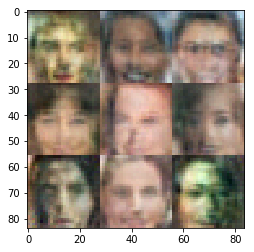

Epoch 1/1... Step 2820... Discriminator Loss: 0.9657... Generator Loss: 0.7674
Epoch 1/1... Step 2840... Discriminator Loss: 1.0840... Generator Loss: 0.6486
Epoch 1/1... Step 2860... Discriminator Loss: 0.3458... Generator Loss: 2.4903
Epoch 1/1... Step 2880... Discriminator Loss: 0.6328... Generator Loss: 1.3280
Epoch 1/1... Step 2900... Discriminator Loss: 1.5258... Generator Loss: 0.5766


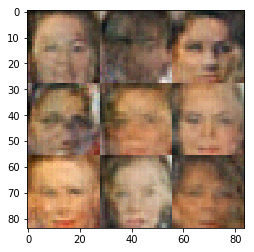

Epoch 1/1... Step 2920... Discriminator Loss: 1.6135... Generator Loss: 0.3587
Epoch 1/1... Step 2940... Discriminator Loss: 0.8141... Generator Loss: 1.1607
Epoch 1/1... Step 2960... Discriminator Loss: 0.3045... Generator Loss: 2.1853
Epoch 1/1... Step 2980... Discriminator Loss: 0.6945... Generator Loss: 1.7632
Epoch 1/1... Step 3000... Discriminator Loss: 1.3693... Generator Loss: 0.4074


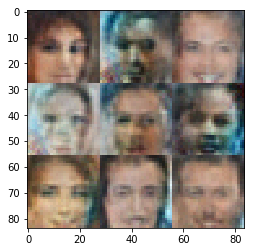

Epoch 1/1... Step 3020... Discriminator Loss: 1.3040... Generator Loss: 0.7335
Epoch 1/1... Step 3040... Discriminator Loss: 1.3072... Generator Loss: 0.5564
Epoch 1/1... Step 3060... Discriminator Loss: 0.7001... Generator Loss: 1.0239
Epoch 1/1... Step 3080... Discriminator Loss: 2.5148... Generator Loss: 0.1094
Epoch 1/1... Step 3100... Discriminator Loss: 2.9123... Generator Loss: 0.8577


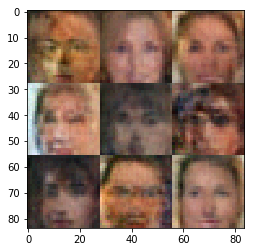

Epoch 1/1... Step 3120... Discriminator Loss: 1.2414... Generator Loss: 0.7186
Epoch 1/1... Step 3140... Discriminator Loss: 1.3022... Generator Loss: 0.5539
Epoch 1/1... Step 3160... Discriminator Loss: 1.1560... Generator Loss: 0.7805
Epoch 1/1... Step 3180... Discriminator Loss: 0.8775... Generator Loss: 1.3182
Epoch 1/1... Step 3200... Discriminator Loss: 0.4100... Generator Loss: 4.3651


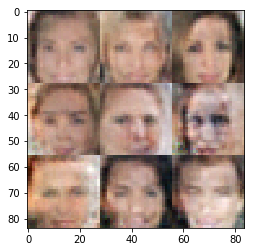

Epoch 1/1... Step 3220... Discriminator Loss: 0.8347... Generator Loss: 2.2024
Epoch 1/1... Step 3240... Discriminator Loss: 1.3034... Generator Loss: 0.4843
Epoch 1/1... Step 3260... Discriminator Loss: 0.5872... Generator Loss: 1.7993
Epoch 1/1... Step 3280... Discriminator Loss: 1.0393... Generator Loss: 1.2721
Epoch 1/1... Step 3300... Discriminator Loss: 1.6846... Generator Loss: 0.3297


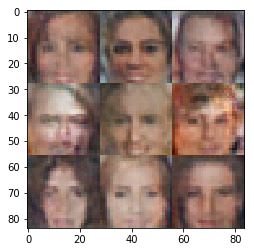

Epoch 1/1... Step 3320... Discriminator Loss: 0.4710... Generator Loss: 1.9952
Epoch 1/1... Step 3340... Discriminator Loss: 0.4133... Generator Loss: 1.9957
Epoch 1/1... Step 3360... Discriminator Loss: 1.5771... Generator Loss: 0.3050
Epoch 1/1... Step 3380... Discriminator Loss: 0.5408... Generator Loss: 1.8387
Epoch 1/1... Step 3400... Discriminator Loss: 0.9060... Generator Loss: 1.3841


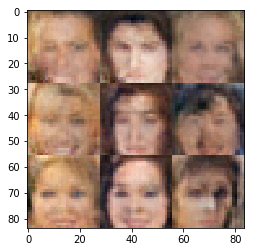

Epoch 1/1... Step 3420... Discriminator Loss: 0.5660... Generator Loss: 3.1403
Epoch 1/1... Step 3440... Discriminator Loss: 1.2636... Generator Loss: 0.5575
Epoch 1/1... Step 3460... Discriminator Loss: 0.8118... Generator Loss: 1.0975
Epoch 1/1... Step 3480... Discriminator Loss: 0.9501... Generator Loss: 0.8457
Epoch 1/1... Step 3500... Discriminator Loss: 1.2833... Generator Loss: 0.5857


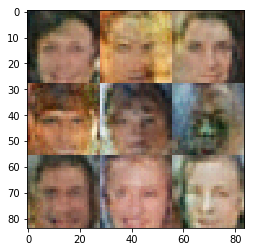

Epoch 1/1... Step 3520... Discriminator Loss: 1.4928... Generator Loss: 0.4423
Epoch 1/1... Step 3540... Discriminator Loss: 1.0157... Generator Loss: 0.8560
Epoch 1/1... Step 3560... Discriminator Loss: 1.5713... Generator Loss: 0.3549
Epoch 1/1... Step 3580... Discriminator Loss: 0.2667... Generator Loss: 4.7376
Epoch 1/1... Step 3600... Discriminator Loss: 2.8107... Generator Loss: 0.0859


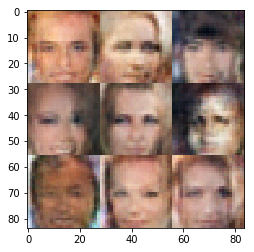

Epoch 1/1... Step 3620... Discriminator Loss: 0.6603... Generator Loss: 1.1311
Epoch 1/1... Step 3640... Discriminator Loss: 0.4944... Generator Loss: 2.0886
Epoch 1/1... Step 3660... Discriminator Loss: 0.6982... Generator Loss: 1.5707
Epoch 1/1... Step 3680... Discriminator Loss: 0.5042... Generator Loss: 1.6875
Epoch 1/1... Step 3700... Discriminator Loss: 1.2046... Generator Loss: 0.7874


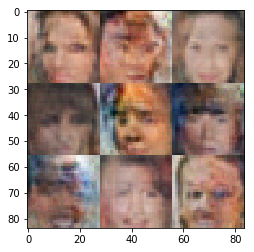

Epoch 1/1... Step 3720... Discriminator Loss: 1.1041... Generator Loss: 1.0453
Epoch 1/1... Step 3740... Discriminator Loss: 0.4728... Generator Loss: 3.2740
Epoch 1/1... Step 3760... Discriminator Loss: 0.9407... Generator Loss: 0.7135
Epoch 1/1... Step 3780... Discriminator Loss: 1.1736... Generator Loss: 0.6934
Epoch 1/1... Step 3800... Discriminator Loss: 0.4892... Generator Loss: 1.4734


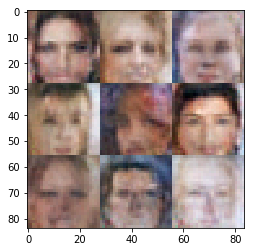

Epoch 1/1... Step 3820... Discriminator Loss: 1.0898... Generator Loss: 3.7783
Epoch 1/1... Step 3840... Discriminator Loss: 0.5357... Generator Loss: 1.5236
Epoch 1/1... Step 3860... Discriminator Loss: 1.4607... Generator Loss: 1.9209
Epoch 1/1... Step 3880... Discriminator Loss: 1.6068... Generator Loss: 0.3721
Epoch 1/1... Step 3900... Discriminator Loss: 1.2046... Generator Loss: 0.7461


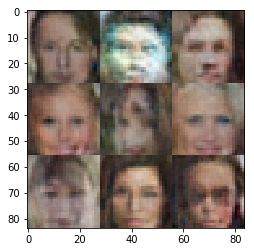

Epoch 1/1... Step 3920... Discriminator Loss: 1.3236... Generator Loss: 0.5599
Epoch 1/1... Step 3940... Discriminator Loss: 0.7518... Generator Loss: 1.2189
Epoch 1/1... Step 3960... Discriminator Loss: 1.1644... Generator Loss: 0.6514
Epoch 1/1... Step 3980... Discriminator Loss: 0.4538... Generator Loss: 1.7193
Epoch 1/1... Step 4000... Discriminator Loss: 1.8796... Generator Loss: 0.2798


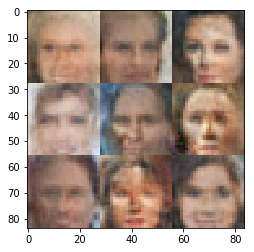

Epoch 1/1... Step 4020... Discriminator Loss: 0.4213... Generator Loss: 1.7646
Epoch 1/1... Step 4040... Discriminator Loss: 1.2054... Generator Loss: 1.2998
Epoch 1/1... Step 4060... Discriminator Loss: 0.2075... Generator Loss: 3.3397
Epoch 1/1... Step 4080... Discriminator Loss: 3.0151... Generator Loss: 0.0666
Epoch 1/1... Step 4100... Discriminator Loss: 1.7133... Generator Loss: 0.3072


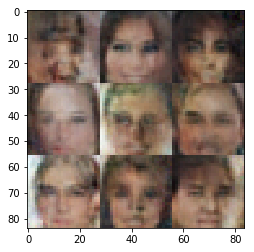

Epoch 1/1... Step 4120... Discriminator Loss: 0.7524... Generator Loss: 1.6230
Epoch 1/1... Step 4140... Discriminator Loss: 0.7790... Generator Loss: 1.8746
Epoch 1/1... Step 4160... Discriminator Loss: 1.7490... Generator Loss: 0.2771
Epoch 1/1... Step 4180... Discriminator Loss: 1.4039... Generator Loss: 0.4947
Epoch 1/1... Step 4200... Discriminator Loss: 0.2204... Generator Loss: 2.4402


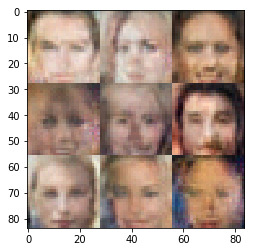

Epoch 1/1... Step 4220... Discriminator Loss: 1.4274... Generator Loss: 0.5867
Epoch 1/1... Step 4240... Discriminator Loss: 1.5889... Generator Loss: 0.3194
Epoch 1/1... Step 4260... Discriminator Loss: 0.5914... Generator Loss: 1.5013
Epoch 1/1... Step 4280... Discriminator Loss: 1.1109... Generator Loss: 0.6854
Epoch 1/1... Step 4300... Discriminator Loss: 1.8374... Generator Loss: 0.2170


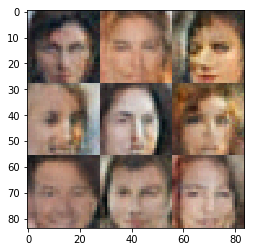

Epoch 1/1... Step 4320... Discriminator Loss: 0.8263... Generator Loss: 1.9998
Epoch 1/1... Step 4340... Discriminator Loss: 1.5039... Generator Loss: 0.3694
Epoch 1/1... Step 4360... Discriminator Loss: 0.2790... Generator Loss: 5.1919
Epoch 1/1... Step 4380... Discriminator Loss: 0.3588... Generator Loss: 3.0710
Epoch 1/1... Step 4400... Discriminator Loss: 1.6961... Generator Loss: 8.7259


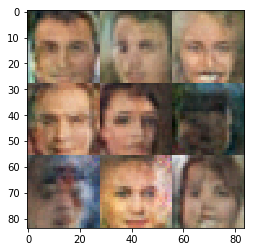

Epoch 1/1... Step 4420... Discriminator Loss: 1.0600... Generator Loss: 0.7701
Epoch 1/1... Step 4440... Discriminator Loss: 1.2383... Generator Loss: 0.6660
Epoch 1/1... Step 4460... Discriminator Loss: 0.8722... Generator Loss: 0.8700
Epoch 1/1... Step 4480... Discriminator Loss: 1.0900... Generator Loss: 1.5936
Epoch 1/1... Step 4500... Discriminator Loss: 1.3107... Generator Loss: 0.5390


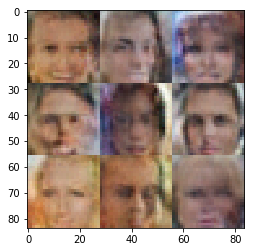

Epoch 1/1... Step 4520... Discriminator Loss: 1.4745... Generator Loss: 0.4137
Epoch 1/1... Step 4540... Discriminator Loss: 1.7498... Generator Loss: 0.2952
Epoch 1/1... Step 4560... Discriminator Loss: 0.7399... Generator Loss: 1.1997
Epoch 1/1... Step 4580... Discriminator Loss: 0.5043... Generator Loss: 5.0471
Epoch 1/1... Step 4600... Discriminator Loss: 0.2883... Generator Loss: 3.9207


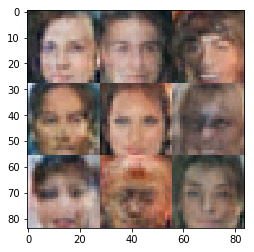

Epoch 1/1... Step 4620... Discriminator Loss: 0.7284... Generator Loss: 1.5931
Epoch 1/1... Step 4640... Discriminator Loss: 0.2010... Generator Loss: 5.2988
Epoch 1/1... Step 4660... Discriminator Loss: 1.2308... Generator Loss: 0.6498
Epoch 1/1... Step 4680... Discriminator Loss: 2.1952... Generator Loss: 0.1502
Epoch 1/1... Step 4700... Discriminator Loss: 1.1688... Generator Loss: 0.5800


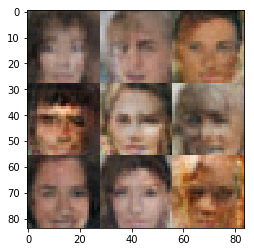

Epoch 1/1... Step 4720... Discriminator Loss: 1.2261... Generator Loss: 0.5346
Epoch 1/1... Step 4740... Discriminator Loss: 0.5142... Generator Loss: 1.8538
Epoch 1/1... Step 4760... Discriminator Loss: 0.2486... Generator Loss: 4.1208
Epoch 1/1... Step 4780... Discriminator Loss: 1.0983... Generator Loss: 0.8148
Epoch 1/1... Step 4800... Discriminator Loss: 0.2694... Generator Loss: 3.7532


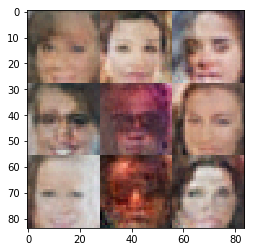

Epoch 1/1... Step 4820... Discriminator Loss: 0.6654... Generator Loss: 2.1104
Epoch 1/1... Step 4840... Discriminator Loss: 1.4394... Generator Loss: 0.4637
Epoch 1/1... Step 4860... Discriminator Loss: 0.9486... Generator Loss: 0.6916
Epoch 1/1... Step 4880... Discriminator Loss: 0.1868... Generator Loss: 8.2440
Epoch 1/1... Step 4900... Discriminator Loss: 1.4954... Generator Loss: 0.3640


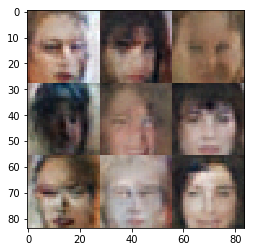

Epoch 1/1... Step 4920... Discriminator Loss: 0.5751... Generator Loss: 1.3881
Epoch 1/1... Step 4940... Discriminator Loss: 0.3459... Generator Loss: 8.0052
Epoch 1/1... Step 4960... Discriminator Loss: 0.1381... Generator Loss: 4.9256
Epoch 1/1... Step 4980... Discriminator Loss: 0.5475... Generator Loss: 1.8593
Epoch 1/1... Step 5000... Discriminator Loss: 2.3164... Generator Loss: 0.1657


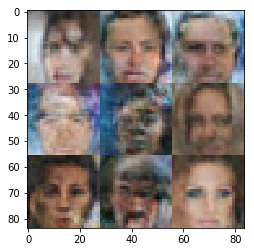

Epoch 1/1... Step 5020... Discriminator Loss: 0.5858... Generator Loss: 1.3695
Epoch 1/1... Step 5040... Discriminator Loss: 2.0727... Generator Loss: 0.1650
Epoch 1/1... Step 5060... Discriminator Loss: 0.5698... Generator Loss: 4.5960
Epoch 1/1... Step 5080... Discriminator Loss: 0.4563... Generator Loss: 1.4112
Epoch 1/1... Step 5100... Discriminator Loss: 1.3308... Generator Loss: 0.7248


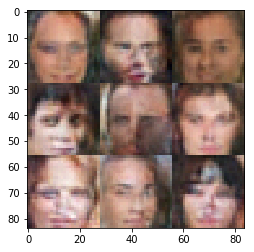

Epoch 1/1... Step 5120... Discriminator Loss: 1.3018... Generator Loss: 0.4216
Epoch 1/1... Step 5140... Discriminator Loss: 1.5652... Generator Loss: 0.5487
Epoch 1/1... Step 5160... Discriminator Loss: 1.2928... Generator Loss: 0.4861
Epoch 1/1... Step 5180... Discriminator Loss: 0.7994... Generator Loss: 3.3691
Epoch 1/1... Step 5200... Discriminator Loss: 1.6219... Generator Loss: 0.3781


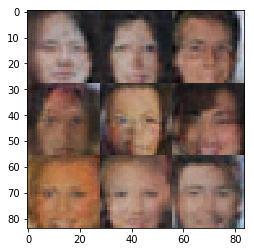

Epoch 1/1... Step 5220... Discriminator Loss: 1.2481... Generator Loss: 0.5544
Epoch 1/1... Step 5240... Discriminator Loss: 0.8888... Generator Loss: 1.1690
Epoch 1/1... Step 5260... Discriminator Loss: 1.0055... Generator Loss: 0.7214
Epoch 1/1... Step 5280... Discriminator Loss: 1.7458... Generator Loss: 0.7894
Epoch 1/1... Step 5300... Discriminator Loss: 2.0103... Generator Loss: 0.1813


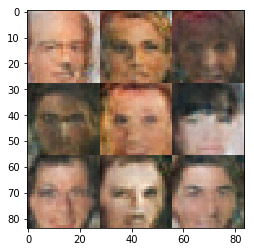

Epoch 1/1... Step 5320... Discriminator Loss: 0.5845... Generator Loss: 1.3623
Epoch 1/1... Step 5340... Discriminator Loss: 1.0330... Generator Loss: 1.2177
Epoch 1/1... Step 5360... Discriminator Loss: 0.4644... Generator Loss: 1.7293
Epoch 1/1... Step 5380... Discriminator Loss: 0.4072... Generator Loss: 1.7776
Epoch 1/1... Step 5400... Discriminator Loss: 1.2337... Generator Loss: 1.4160


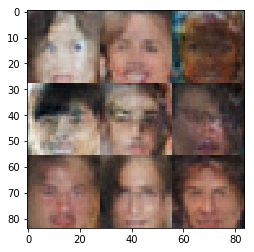

Epoch 1/1... Step 5420... Discriminator Loss: 0.7375... Generator Loss: 1.0448
Epoch 1/1... Step 5440... Discriminator Loss: 0.8332... Generator Loss: 0.8556
Epoch 1/1... Step 5460... Discriminator Loss: 0.4353... Generator Loss: 2.4800
Epoch 1/1... Step 5480... Discriminator Loss: 1.7157... Generator Loss: 0.3600
Epoch 1/1... Step 5500... Discriminator Loss: 0.4036... Generator Loss: 4.0536


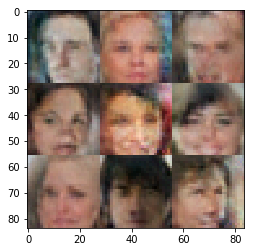

Epoch 1/1... Step 5520... Discriminator Loss: 0.9385... Generator Loss: 3.4938
Epoch 1/1... Step 5540... Discriminator Loss: 1.2810... Generator Loss: 0.4574
Epoch 1/1... Step 5560... Discriminator Loss: 0.1732... Generator Loss: 3.3762
Epoch 1/1... Step 5580... Discriminator Loss: 1.2029... Generator Loss: 0.7934
Epoch 1/1... Step 5600... Discriminator Loss: 1.3962... Generator Loss: 0.4638


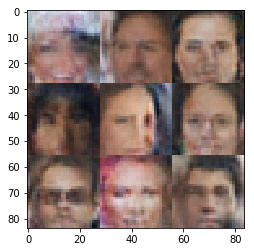

Epoch 1/1... Step 5620... Discriminator Loss: 1.0887... Generator Loss: 0.5820
Epoch 1/1... Step 5640... Discriminator Loss: 1.1429... Generator Loss: 0.5750
Epoch 1/1... Step 5660... Discriminator Loss: 0.2990... Generator Loss: 3.6608
Epoch 1/1... Step 5680... Discriminator Loss: 0.9565... Generator Loss: 0.7904
Epoch 1/1... Step 5700... Discriminator Loss: 1.5827... Generator Loss: 0.4037


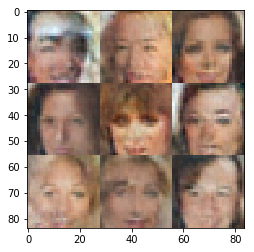

Epoch 1/1... Step 5720... Discriminator Loss: 0.9708... Generator Loss: 0.8638
Epoch 1/1... Step 5740... Discriminator Loss: 1.3516... Generator Loss: 0.5557
Epoch 1/1... Step 5760... Discriminator Loss: 1.3405... Generator Loss: 0.4453
Epoch 1/1... Step 5780... Discriminator Loss: 1.4556... Generator Loss: 0.4608
Epoch 1/1... Step 5800... Discriminator Loss: 1.7134... Generator Loss: 0.3245


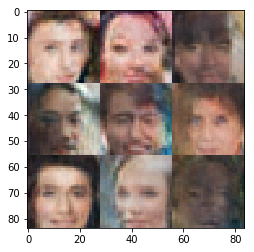

Epoch 1/1... Step 5820... Discriminator Loss: 1.5882... Generator Loss: 0.3631
Epoch 1/1... Step 5840... Discriminator Loss: 1.2358... Generator Loss: 0.5425
Epoch 1/1... Step 5860... Discriminator Loss: 1.4446... Generator Loss: 0.4663
Epoch 1/1... Step 5880... Discriminator Loss: 1.5511... Generator Loss: 0.4596
Epoch 1/1... Step 5900... Discriminator Loss: 1.3212... Generator Loss: 0.5338


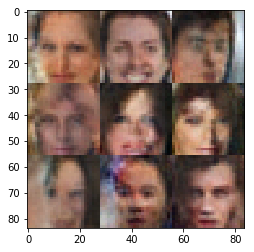

Epoch 1/1... Step 5920... Discriminator Loss: 0.4297... Generator Loss: 2.2053
Epoch 1/1... Step 5940... Discriminator Loss: 0.8248... Generator Loss: 0.9352
Epoch 1/1... Step 5960... Discriminator Loss: 1.4969... Generator Loss: 0.7302
Epoch 1/1... Step 5980... Discriminator Loss: 0.5593... Generator Loss: 2.8986
Epoch 1/1... Step 6000... Discriminator Loss: 1.3496... Generator Loss: 0.5287


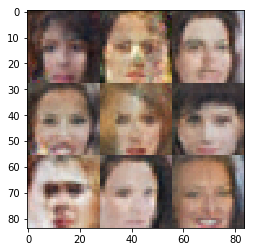

Epoch 1/1... Step 6020... Discriminator Loss: 1.6278... Generator Loss: 1.0913
Epoch 1/1... Step 6040... Discriminator Loss: 0.9071... Generator Loss: 1.0918
Epoch 1/1... Step 6060... Discriminator Loss: 1.0652... Generator Loss: 1.1650
Epoch 1/1... Step 6080... Discriminator Loss: 2.0915... Generator Loss: 0.1741
Epoch 1/1... Step 6100... Discriminator Loss: 1.7061... Generator Loss: 0.2672


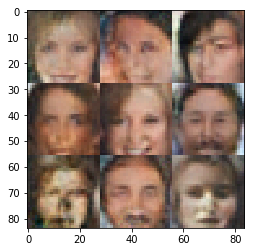

Epoch 1/1... Step 6120... Discriminator Loss: 1.6577... Generator Loss: 0.3721
Epoch 1/1... Step 6140... Discriminator Loss: 0.9711... Generator Loss: 0.7478
Epoch 1/1... Step 6160... Discriminator Loss: 0.1124... Generator Loss: 4.5046
Epoch 1/1... Step 6180... Discriminator Loss: 3.7334... Generator Loss: 2.7132
Epoch 1/1... Step 6200... Discriminator Loss: 1.5696... Generator Loss: 0.3978


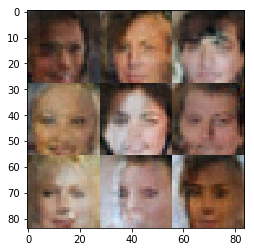

Epoch 1/1... Step 6220... Discriminator Loss: 1.3523... Generator Loss: 0.4877
Epoch 1/1... Step 6240... Discriminator Loss: 1.1018... Generator Loss: 0.6709
Epoch 1/1... Step 6260... Discriminator Loss: 0.9671... Generator Loss: 0.7409
Epoch 1/1... Step 6280... Discriminator Loss: 1.2839... Generator Loss: 0.4304
Epoch 1/1... Step 6300... Discriminator Loss: 1.8245... Generator Loss: 0.3071


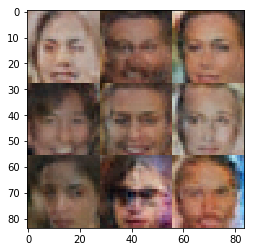

Epoch 1/1... Step 6320... Discriminator Loss: 0.4293... Generator Loss: 3.4792


IndexError: list index out of range

In [54]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.